In [1]:
#coding:utf-8
import pandas as pd
import numpy as np
import time
import datetime
import gc
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [3]:
path = '../data/'
data = pd.read_csv(path+"all_final_data_11-28-12-33.csv")

In [4]:
len(data.columns)

73

In [5]:
data.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day_x', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2',
       'item_maphour_cnt_ratio', 'user_hour_cnt_ratio',
       'user_maphour_cnt_ratio', 'same_time_expo_cnt', 'user_mean_hour',
       'item_mean_hour', 'brand_mean_hour', 'shop_mean_hour', 'user_mean_age',
       'item_mean_age', 'brand_mean_age', 'shop_mean_age', 'user_active_hour',
       'user_day_active_city', 'item_day_active_user', 'shop_day_active_user',
       'b

In [6]:
train = pd.read_csv(path+"train_all.csv")
train = train[['instance_id']]
train

,instance_id
0,5.089880e+18
1,2.163600e+18
2,8.229730e+18
3,8.978460e+18
4,3.831630e+18
...,...
79263,1.000380e+18
79264,9.126350e+18
79265,1.583620e+18
79266,4.525820e+18


In [7]:
train =pd.merge(train, data, how='left', on='instance_id')

In [8]:
train.head()

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,i_day_diffTime_first,i_day_diffTime_last,b_day_diffTime_first,b_day_diffTime_last,s_day_diffTime_first,s_day_diffTime_last,user_id_lasttime_diff,item_id_lasttime_diff,user_id_nexttime_diff,item_id_nexttime_diff
0,5.089880e+18,2769,5982,2,6,11,10,17,60637,0,...,-1,-1,-1,-1,-1,-1,-1,176956,-1,-176956
1,2.163600e+18,16242,4705,147,6,9,10,16,33155,0,...,-1,-1,-1,-1,-1,-1,-1,217323,-1,-217323
2,8.229730e+18,7731,5385,80,4,12,12,13,38351,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,8.978460e+18,68,3543,128,9,4,5,11,91026,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,3.831630e+18,556,6156,103,5,11,9,14,55740,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [9]:
def feat_select(train, test):
  
    features = train.drop(['is_trade', 'time', 'context_timestamp','user_id','context_id','instance_id','item_id','shop_id','item_brand_id'], axis=1).columns.tolist() #,'item_property_list','predict_category_property'

    target = ['is_trade']

    return features, target

In [10]:
def lgbCV(train, test, All):
    features, target = feat_select(train, test)

    lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05)
    # lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05, n_estimators=2000,
    #                            max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
    #                            min_child_weight=5, min_child_samples=10, subsample=1, subsample_freq=1,
    #                            colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, nthread=-1, silent=True)

    lgb_model = lgb_clf.fit(train[features], train[target], eval_set=[(test[features], test[target])], early_stopping_rounds=200)
    best_iter = lgb_model.best_iteration_ 
    
    # 特征重要性
    lgb_predictors = [i for i in train[features].columns]
    lgb_feat_imp = pd.Series(lgb_model.feature_importances_, lgb_predictors).sort_values(ascending=False)
    lgb_feat_imp.to_csv('lgb_feat_imp.csv')
    
    # 训练模型
    lgb_clf.fit(train[features], train[target])
    test['lgb_predict'] = lgb_clf.predict_proba(test[features])[:, 1]
    lgb_loss = log_loss(test[target], test['lgb_predict'])  
    lgb_auc = roc_auc_score(test[target], test['lgb_predict'])
    print('Training loss: %.6f, Training AUC: %.6f' % (lgb_loss, lgb_auc))
    
    return best_iter,lgb_model

In [11]:
test = pd.read_csv(path+"test_all.csv")
test = test[['instance_id']]
test = pd.merge(test, data, how='left', on='instance_id')

In [12]:
All = True
best_iter, lgb_model = lgbCV(train, test, All)

c:\users\hp\downloads\python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\downloads\python39\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\downloads\python39\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0709702
[2]	valid_0's binary_logloss: 0.0704636
[3]	valid_0's binary_logloss: 0.0700644
[4]	valid_0's binary_logloss: 0.0697108
[5]	valid_0's binary_logloss: 0.0693341
[6]	valid_0's binary_logloss: 0.0690558
[7]	valid_0's binary_logloss: 0.0688572
[8]	valid_0's binary_logloss: 0.0686793
[9]	valid_0's binary_logloss: 0.06842
[10]	valid_0's binary_logloss: 0.0682907
[11]	valid_0's binary_logloss: 0.0680597
[12]	valid_0's binary_logloss: 0.0679363
[13]	valid_0's binary_logloss: 0.0678088
[14]	valid_0's binary_logloss: 0.0676602
[15]	valid_0's binary_logloss: 0.0674734
[16]	valid_0's binary_logloss: 0.0673746
[17]	valid_0's binary_logloss: 0.067247
[18]	valid_0's binary_logloss: 0.0671346
[19]	valid_0's binary_logloss: 0.0671356
[20]	valid_0's binary_logloss: 0.0670049
[21]	valid_0's binary_logloss: 0.0669854
[22]	valid_0's binary_logloss: 0.0668928
[23]	valid_0's binary_logloss: 0.0668362
[24]	valid_0's binary_logloss: 0.0667727
[25]	valid_0's binary_loglos

c:\users\hp\downloads\python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\downloads\python39\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training loss: 0.065765, Training AUC: 0.762229


In [13]:
best_iter

62

In [19]:
features, target = feat_select(train, test)
# test[features], test[target]
predictions = lgb_model.predict(train[features])

In [20]:
from sklearn.metrics import confusion_matrix
actuals = train[target]
print("混淆矩阵:")
print(confusion_matrix(actuals, predictions))

混淆矩阵:
[[78140     0]
 [ 1098    30]]


In [26]:
pd.DataFrame(predictions).value_counts()

0    79238
1       30
dtype: int64

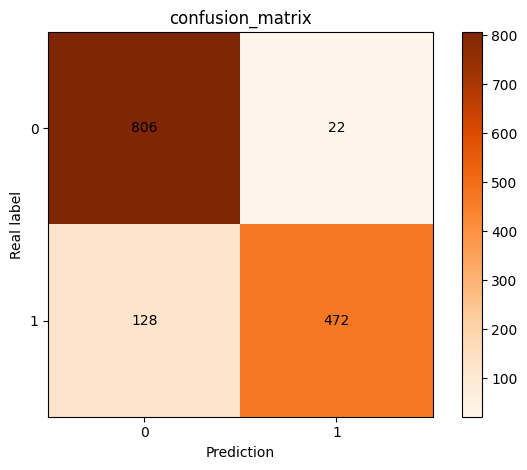

In [35]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['0', '1']#标签列表
confusion_matrix = np.array(([806,22], [128,472]))#二维混淆矩阵

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Oranges)  # 按照像素显示出矩阵
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)  # 倾斜
plt.yticks(tick_marks, classes)

thresh = confusion_matrix.max() / 2.
# iters = [[i,j] for i in range(len(classes)) for j in range((classes))]
# ij配对，遍历矩阵迭代器
iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (confusion_matrix.size, 2))
for i, j in iters:
    plt.text(j, i, format(confusion_matrix[i, j]), va='center', ha='center')  # 显示对应的数字

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
